In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import glob, os
import pylab
import sklearn
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import chi2
import timeit
%matplotlib inline

In [2]:
# Format to remove scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Reading data

In [3]:
#apc_1203
start = timeit.default_timer()
store = pd.HDFStore(r'R:\Angela\fast_trips\apc_1203.h5')
data1 = store['APCdata']
stop = timeit.default_timer()
print 'apc_1203:', stop - start 

apc_1203: 49.037491156


In [4]:
#apc_1206
start = timeit.default_timer()
store = pd.HDFStore(r'R:\Angela\fast_trips\apc_1206.h5')
data2 = store['APCdata']
stop = timeit.default_timer()
print 'apc_1206:', stop - start 

apc_1206: 26.5426354858


In [ ]:
#apc_1209
start = timeit.default_timer()
store = pd.HDFStore(r'R:\Angela\fast_trips\apc_1209.h5')
data3 = store['APCdata']
stop = timeit.default_timer()
print 'apc_1209:', stop - start 

In [5]:
def data_need(data):
    data = data[['on', 'off', 'vehno', 'route', 'stop_name', 'stop_sequence', 'mo', 'yr', 'arr_hour', 'arr_min', 'arr_sec', 'dep_hr', 'dep_min', 'dep_sec']]
    return data
data1 = data_need(data1)
data2 = data_need(data2)
#data3 = data_need(data3)

combined_data = pd.concat([data1, data2])
print len(combined_data)
#in this case, we applied data1 and data2
#if you decided to go with the whole dataset
#combined_data = pd.read_csv(r'R:\Angela\fast_trips\apc_1203_1206_1209.csv')

print "finished combining data"

19875614
finished combining data


# Data to apply

In [6]:
#for now, the datasets applied are apc_1203 data and apc_1209 data
#test 30% of the combined_data
test_percent = 0.3
test_percent_title = str(test_percent)
msk = np.random.rand(len(combined_data)) < (1-test_percent)
test = combined_data[~msk]
print len(test)

5961254


#Prepare bus info

In [7]:
vehicles = pd.read_csv(r'R:\Angela\fast_trips\Vehicles.csv')
fleet = pd.read_csv(r'R:\Angela\fast_trips\Copy of Fleet.csv')
vehicles.Artic = vehicles.Length.map({60 : 1, 40 : 0, 30 : 0})
vehicles.Floor = vehicles['Low Floor'].map({'Y': 1, 'N' : 0})
vehicles.loc[:,'Artic'] = pd.Series(vehicles.Artic, index=vehicles.index)
vehicles.loc[:,'Floor'] = pd.Series(vehicles.Floor, index=vehicles.index)
df_artic = vehicles.set_index('Equip_Type').to_dict()['Artic']
df_floor = vehicles.set_index('Equip_Type').to_dict()['Floor']
df_doors = vehicles.set_index('Equip_Type').to_dict()['Doors']
fleet['Doors'] = fleet['Equip_Type'].map(df_doors)
fleet['Artic'] = fleet['Equip_Type'].map(df_artic)
fleet['Floor'] = fleet['Equip_Type'].map(df_floor)
df_vehnum_doors = fleet.set_index('VehNum').to_dict()['Doors']
df_vehnum_artic = fleet.set_index('VehNum').to_dict()['Artic']
df_vehnum_floor = fleet.set_index('VehNum').to_dict()['Floor']

# Prepare route type

In [8]:
route_type = pd.read_csv(r'R:\Angela\fast_trips\MuniRouteTypes.csv')
route_type = route_type.dropna()
dict_route_type = {}
dict_route_type = route_type.set_index('APC Route ID')['Type'].to_dict()

# Variables

In [9]:
def get_x_y(data):
    start = timeit.default_timer()
    #Get rid of rows where certain fields has null/nan values
    data = data.dropna(subset = ['on', 'off', 'vehno'])
    #input bus type info into raw data
    #COMPUTE EOL = RINDEX(ANAME,' - EOL') 
    data['EOL']= data.apply(lambda x: '- EOL' in x['stop_name'], axis=1).map({False: 1, True: 0})
    #remove the last stop
    data = data.loc[data['EOL'] == 1]
    #remove the first stop
    data = data.loc[data['stop_sequence'] != 1]
    stop = timeit.default_timer()
    print 'clean data:', stop - start

    #COMPUTE TIMESTOP=((HR * 3600) + (MIN * 60) + SEC)
    start = timeit.default_timer()
    data['COMPUTE_TIMESTOP'] = data['arr_hour']*3600 + data['arr_min']*60 + data['arr_sec']
    #COMPUTE DOORCLOSE=(( DHR * 3600) + (DMIN * 60) + DSEC)
    data['COMPUTE_DOORCOLSE'] = data['dep_hr']*3600 + data['dep_min']*60 + data['dep_sec']
    #COMPUTE DOORDWELL=DOORCLOSE - TIMESTOP
    data['COMPUTE_DOORDWELL'] = data['COMPUTE_DOORCOLSE'] - data['COMPUTE_TIMESTOP']
    #appling door dwell time less than 120 secs
    data = data.loc[data['COMPUTE_DOORDWELL'] <= 120]
    stop = timeit.default_timer()
    print 'compute dwell time:', stop - start

    #Keep rows that satisfy a query:
    start = timeit.default_timer()
    data['Doors'] = data['vehno'].map(df_vehnum_doors) 
    data['Artic'] = data['vehno'].map(df_vehnum_artic)
    data['Floor'] = data['vehno'].map(df_vehnum_floor)
    data['two_doors'] = data['Doors'].map({2: 1, 3: 0})
    data['three_doors'] = data['Doors'].map({2: 0, 3: 1})
    data['all_door_boarding']= data.apply(lambda x: x['mo'] > 6, axis=1).map({False: 0, True: 1})
    #Create dummie variables for route id
    data['Route Type'] = data['route'].map(dict_route_type)
    just_dummies_route = pd.get_dummies(data['Route Type'])
    step_1 = pd.concat([data, just_dummies_route], axis=1)
    step_1.drop(['Local'], inplace=True, axis=1)
    data = step_1
    stop = timeit.default_timer()
    print 'add veh&route info:', stop - start

    #Create interaction variables
    start = timeit.default_timer()
    data['on_threedoors'] = data['on']*data['three_doors']
    data['off_threedoors'] = data['off']*data['three_doors']
    data['on_floor'] = data['on']*data['Floor']
    data['off_floor'] = data['off']*data['Floor']
    data['floor_threedoors'] = data['Floor']*data['three_doors']
    data['floor_twodoors'] = data['Floor']*data['two_doors']
    data['on_all_door_boarding'] = data['on']*data['all_door_boarding']
    data['off_all_door_boarding'] = data['off']*data['all_door_boarding']
    data['on_express'] = data['on']*data['Express']
    data['off_express'] = data['off']*data['Express']
    data['on_rapid'] = data['on']*data['Rapid']
    data['off_rapid'] = data['off']*data['Rapid']
    data['on_owl'] = data['on']*data['OWL']
    data['off_owl'] = data['off']*data['OWL']
    stop = timeit.default_timer()
    print 'add interaction variables:', stop - start

    return data

In [10]:
#Create dummie variables for bus id 
def create_vehID(data):
    start = timeit.default_timer()
    just_dummies_veh = pd.get_dummies(data['vehno'])
    data = pd.concat([data, just_dummies_veh], axis=1)
    #get rid of one dummy variable to avoid the dummy variable trap
    #step_1.drop([8515], inplace=True, axis=1)
    stop = timeit.default_timer()
    print 'add bus id variables:', stop - start
    return data

In [11]:
#to check whether vehcle:8515 is in the sample, if it is not, we should pick up another veh id to delete
#for every route type, get rid of one dummy bus id variable, to avoid the dummy variable trap
#step1 = data.drop([owl_veh], inplace=True, axis=1)
def del_vehID(data):
    express = data.loc[data['Express'] == 1]
    express_veh = np.unique(express['vehno'])[1]
    print express_veh
    rapid = data.loc[data['Rapid'] == 1]
    rapid_veh = np.unique(rapid['vehno'])[1]
    print rapid_veh
    owl = data.loc[data['OWL'] == 1]
    owl_veh = np.unique(owl['vehno'])[1]
    print owl_veh
    print data.shape
    data = data.drop([express_veh, rapid_veh, owl_veh], 1)
    print data.shape
    
    return data

In [12]:
step1 = get_x_y(test)
step2 = create_vehID(step1)
step3 = del_vehID(step2)
print 'finished data preparation'

clean data: 72.0059641385
compute dwell time: 2.64435364302
add veh&route info: 71.8595594645
add interaction variables: 0.389088273717
add bus id variables: 43.0666269641
2802
5464
6201
(5655163, 280)
(5655163, 277)
finished data preparation


# Build multi-linear regression model

# Model - with vehicle ids

In [14]:
#Run Linear Regression In Python SciKit-Learn
start = timeit.default_timer()
X = step3.drop(['COMPUTE_DOORDWELL','vehno','stop_name', 'stop_sequence', 'arr_hour','arr_min',
               'arr_sec','route','mo','yr','dep_hr','dep_min','dep_sec', 'EOL',
               'COMPUTE_TIMESTOP','COMPUTE_DOORCOLSE','COMPUTE_DOORDWELL','Doors',
               'two_doors', 'Artic', 'Route Type', 'floor_threedoors', 
               'floor_twodoors'], axis=1)
# impute missing values
X[np.isnan(X)] = np.median(X[~np.isnan(X)])
y = step3.COMPUTE_DOORDWELL
print len(X)
print len(y)
stop = timeit.default_timer()
print 'prepare x,y for regression:', stop - start

5655163
5655163
prepare x,y for regression: 7264.58600717


In [15]:
#train 70% data
#validate 30% data
length = len(X) * 0.3
length_index = (-1) * int(length)
X_train = X[:length_index]
X_test = X[length_index:]
y_train = y[:length_index]
y_test = y[length_index:]
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(3958615, 255)
(1696548, 255)
(3958615L,)
(1696548L,)


In [16]:
c = 0
for ele in y:
    if ele < 0:
        print ele
        c += 1
print c

0


In [17]:
start = timeit.default_timer()
lm1 = LinearRegression()
lm1.fit(X_train, y_train)
pred_train = lm1.predict(X_train)
pred_test = lm1.predict(X_test)
LinearRegression(copy_X=True, fit_intercept=True,normalize=False)

#construct a data frame that contains features and estimated coefficients
sklearn_results = pd.DataFrame(zip(X_train.columns, lm1.coef_), columns = ['features', 'estimatedCoefficients'])
#p-values
scores, pvalues = chi2(X_train, y_train)
sklearn_results['pvalues'] = pd.DataFrame(pvalues)
sklearn_results['scores'] = pd.DataFrame(scores)
sklearn_results.to_csv('R:/Angela/fast_trips/muni_apc_2012/30%_1203_1206_datasets_withVeh1.csv')
stop = timeit.default_timer()
print 'build model with veh ids:', stop - start

build model with veh ids: 292.952167965


In [18]:
print sklearn_results

                  features  estimatedCoefficients  pvalues      scores
0                       on                  2.689    0.000 7871640.099
1                      off                  1.702    0.000 5053561.732
2                    Floor        -4455101127.193    0.000   67878.284
3              three_doors                 -1.013    0.000   62233.120
4        all_door_boarding                 -0.176    0.000    1685.373
5                  Express                  1.119    0.000   22367.289
6                      OWL                 -0.229    0.000    2306.957
7                    Rapid                  4.902    0.000   76201.822
8            on_threedoors                  0.021    0.000 3400832.710
9           off_threedoors                 -0.319    0.000 2098038.572
10                on_floor                  0.617    0.000  352514.510
11               off_floor                  0.506    0.000  295719.991
12    on_all_door_boarding                 -0.152    0.000 2602541.244
13   o

# Residual plots

In [19]:
print len(X_train)
print len(y_train)

3958615
3958615


In [20]:
#check whether there is any negative value in (y_train)
c = 0
for ele in y_train:
    if ele < 0:
        print ele
        c += 1
if c == 0:
    print 'there is no nagative value in y_tain'

there is no nagative value in y_tain


In [23]:
#check whether there is any megative value in lm.predict(X_train)
neg_dict = {}
j = 0
for ele in range(1, len(X_train)):
    i = ele-1
    #print i
    if lm1.predict(X_train[i:ele])<0: 
        neg_dict[ele] = lm1.predict(X_train[i:ele])
        j += 1
print neg_dict
print j

{1892352: array([-0.21647219]), 1890987: array([-0.57002109]), 1892356: array([-0.21647219]), 1892359: array([-0.21647219]), 3767161: array([-0.02110555]), 1892361: array([-0.21647219]), 1892362: array([-0.21647219]), 1892363: array([-0.21647219]), 3768332: array([-0.02110555]), 1892366: array([-0.21647219]), 1892367: array([-0.21647219]), 1892369: array([-0.21647219]), 3768338: array([-0.02110555]), 1892355: array([-0.21647219]), 1890990: array([-0.57002109]), 1892374: array([-0.21647219]), 3768343: array([-0.02110555]), 1892376: array([-0.21647219]), 1892378: array([-0.21647219]), 1892379: array([-0.21647219]), 3768348: array([-0.02110555]), 1892381: array([-0.21647219]), 1892384: array([-0.21647219]), 1892385: array([-0.21647219]), 1892387: array([-0.21647219]), 3768356: array([-0.02110555]), 1892390: array([-0.21647219]), 1890993: array([-0.57002109]), 1892392: array([-0.21647219]), 1892394: array([-0.21647219]), 3768327: array([-0.02110555]), 1892396: array([-0.21647219]), 1892397

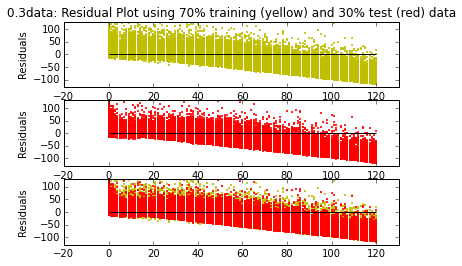

In [61]:
plt.figure(1)

plt.subplot(311)
plt.scatter(y_train, lm1.predict(X_train) - y_train, c='y', s=1,edgecolor='y')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.title(test_percent_title + 'data: Residual Plot using 70% training (yellow) and 30% test (red) data')
plt.ylabel('Residuals')

plt.subplot(312)
plt.scatter(y_test, lm1.predict(X_test) - y_test, c='r', s=1,edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('Residuals')

plt.subplot(313)
plt.scatter(y_train, lm1.predict(X_train) - y_train, c='y', s=1, edgecolor='y')
plt.scatter(y_test, lm1.predict(X_test) - y_test, c='r', s=1, edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('Residuals')
plt.show()

# Model - without vehicle IDs

In [27]:
start = timeit.default_timer()
X2 = step3[['on','off','Floor','three_doors','all_door_boarding','Express','OWL','Rapid','on_threedoors','off_threedoors','on_floor','off_floor','on_all_door_boarding','off_all_door_boarding','on_express','off_express','on_rapid','off_rapid','on_owl','off_owl']]
X2[np.isnan(X2)] = np.median(X2[~np.isnan(X2)])
y2 = step3.COMPUTE_DOORDWELL
print 'done'

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda\lib\site-packages\pandas\core\frame.py:2334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.where(-key, value, inplace=True)


done


In [28]:
X2_train = X2[:length_index]
X2_test = X2[length_index:]
y2_train = y2[:length_index]
y2_test = y2[length_index:]
print X2_train.shape
print X2_test.shape
print y2_train.shape
print y2_test.shape

(3958615, 20)
(1696548, 20)
(3958615L,)
(1696548L,)


In [29]:
lm2 = LinearRegression()
lm2.fit(X2_train, y2_train)
LinearRegression(copy_X=True, fit_intercept=True,normalize=False)

#construct a data frame that contains features and estimated coefficients
sklearn_results = pd.DataFrame(zip(X2_train.columns, lm2.coef_), columns = ['features', 'estimatedCoefficients'])
#p-values
scores, pvalues = chi2(X2_train, y2_train)
sklearn_results['pvalues'] = pd.DataFrame(pvalues)
sklearn_results['scores'] = pd.DataFrame(scores)
sklearn_results.to_csv('R:/Angela/fast_trips/muni_apc_2012/30%_1203_1206_datasets_withoutVeh.csv')
stop = timeit.default_timer()
print 'build model without veh ids:', stop - start

build model without veh ids: 30.7872391161


In [36]:
print sklearn_results

                 features  estimatedCoefficients  pvalues      scores
0                      on                  2.681    0.000 7871640.099
1                     off                  1.694    0.000 5053561.732
2                   Floor                 -2.331    0.000   67878.284
3             three_doors                  1.268    0.000   62233.120
4       all_door_boarding                  0.053    0.000    1685.373
5                 Express                  0.296    0.000   22367.289
6                     OWL                 -0.609    0.000    2306.957
7                   Rapid                  4.224    0.000   76201.822
8           on_threedoors                  0.027    0.000 3400832.710
9          off_threedoors                 -0.314    0.000 2098038.572
10               on_floor                  0.657    0.000  352514.510
11              off_floor                  0.543    0.000  295719.991
12   on_all_door_boarding                 -0.171    0.000 2602541.244
13  off_all_door_boa

# Residual plots

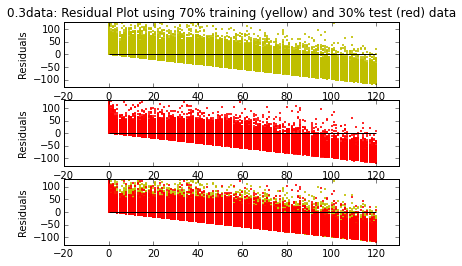

In [60]:
plt.figure(1)
plt.subplot(311)
plt.scatter(y2_train, lm2.predict(X2_train) - y2_train, c='y', s=1,edgecolor='y')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.title(test_percent_title + 'data: Residual Plot using 70% training (yellow) and 30% test (red) data')
plt.ylabel('Residuals')

plt.subplot(312)
plt.scatter(y2_test, lm2.predict(X2_test) - y2_test, c='r', s=1,edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('Residuals')

plt.subplot(313)
plt.scatter(y2_train, lm2.predict(X2_train) - y2_train, c='y', s=1, edgecolor='y')
plt.scatter(y2_test, lm2.predict(X2_test) - y2_test, c='r', s=1, edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('Residuals')

plt.show()

In [50]:
print 'end'

end
